In [1]:
import numpy as np
np.set_printoptions(precision=5)

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib import Lowpass, DoubleExp

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

import time

import neuron
neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
neuron.h.load_file('stdrun.hoc')

	1 


1.0

In [2]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025, DA=False, k_weight=1, conn_opt=False):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        self.DA = DA  # dopaminergic modulation ON/OFF
        self.k_weight = k_weight
        self.conn_opt = conn_opt

    def neuron_rates(self, wgain, wbias, x, n_neurons_test, stage, tau=0.1):
        rate_pos = (40/2) * (x + 1)
        rate_neg = (40/2) * (-x + 1)
        spike_counts = np.zeros_like(n_neurons_test)
        neurons = []
        spk_vecs = []
        spk_recs = []
        stims = []
        syns = []
        ncs = []
        for n in range(n_neurons_test):
            neurons.append(neuron.h.Durstewitz())
            neurons[n].init()
            spk_vecs.append(neuron.h.Vector())
            spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
            spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                if stage == 'gain':
                    # bias spikes
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if wbias < 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias)))
                    ncs[-1].pre().interval = 1
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    w = wgain[n]
                    # positive encoder presynaptic neuron
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, w))
                    ncs[-1].pre().interval = 1000.0 / rate_pos
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    # negative encoder presynaptic neuron
                    if rate_neg <= 0: continue
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, w))
                    ncs[-1].pre().interval = 1000.0 / rate_neg
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                elif stage == 'bias':
                    # bias spikes
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if wbias[n] < 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias[n])))
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    ncs[-1].pre().interval = 1
                    # positive encoder presynaptic neuron
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, wgain))
                    ncs[-1].pre().interval = 1000.0 / rate_pos
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    # negative encoder presynaptic neuron
                    if rate_neg <= 0: continue
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, wgain))
                    ncs[-1].pre().interval = 1000.0 / rate_neg
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
        settle_time = 0.1
        sim_time = 1.0
        neuron.h.tstop = (settle_time+sim_time)*1000
        neuron.h.dt = self.dt_neuron
        neuron.h.run()
        spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
        for n in range(n_neurons_test):
            spk_vecs[n].play_remove()
            del(neurons[0])
        rates = np.array(spike_counts)/sim_time
        return rates
        
    def gain_bias(self, max_rates, intercepts, attempts=30, steps=10, y_thr=2, x_thr=1):
        if self.conn_opt:
            return np.ones_like(max_rates), np.zeros_like(intercepts)
        print('finding gain and bias assuming on/off spiking inputs...')
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
        n_neurons = max_rates.shape[0]
        gain = np.zeros((n_neurons))
        bias = np.zeros((n_neurons))
        for n in range(n_neurons):
            wgain_min = 0.0
            wgain_max = 2e-4
            wbias_min = -2e-5
            wbias_max = 2e-5
            gain_pass = False
            bias_pass = False
            rate_delta = 0
            gain_delta = 0
            bias_delta = 0
            print('target y-int', max_rates[n])
            print('target x-int', intercepts[n])
            for a in range(attempts):
                if a == 0:
                    wbias = 0
                '''find wgain that achieve max_rates[n] at x=1 given previous wbias'''
                if not gain_pass:
                    wgain = np.linspace(wgain_min, wgain_max, steps)
                    y_rates = self.neuron_rates(wgain, wbias, x=1, n_neurons_test=steps, stage='gain')
#                     print('wgain', wgain)
#                     print('y_rates', y_rates)
                    wgain = wgain[np.argmin(np.abs(y_rates - max_rates[n]))]
                    y_int = y_rates[np.argmin(np.abs(y_rates - max_rates[n]))]
                    if (y_rates > 60).any():
                        wgain_max /= 2
                else:
                    y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
                '''find wbias that achieve 0<hz<1 at x=intercept[n] given previous wgain'''
                if not bias_pass:
                    wbias = np.linspace(wbias_min, wbias_max, steps)
                    x_rates = self.neuron_rates(wgain, wbias, x=intercepts[n], n_neurons_test=steps, stage='bias')
#                     print('wbias', wbias)
                    if (x_rates > 60).any():
                        wbias_max *= 2
                        wbias_max /= 2
#                     print('x_rates', x_rates)
                    if (x_rates > x_thr).all() or (x_rates <= 0).all():
                        wbias = wbias[0]
                        x_int = x_rates[0]
                    else:
                        wbias = wbias[np.where(x_rates <= 1)[0][-1]]
                        x_int = x_rates[np.where(x_rates <= 1)[0][-1]]
                else:
                    x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')                  
                a_y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
                a_x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
                print('attempt %s' %a)
                print('rate at y-int', a_y_int)
                print('rate at x-int', a_x_int)
                if a_y_int-a_x_int > rate_delta:
                    rate_delta = a_y_int-a_x_int + 4*(0<a_x_int<=x_thr)  # added value for correct x-int
                    gain_delta = wgain
                    bias_delta = wbias
                if np.abs(a_y_int - max_rates[n]) <= y_thr:
                    gain_pass = True
                elif a_y_int < max_rates[n] - y_thr:
                    wgain_max *= 1.125
                    gain_pass = False
                elif a_y_int > max_rates[n] + y_thr:
                    wgain_max /= 1.125
                    gain_pass = False
                if 0 < a_x_int <= x_thr:
                    bias_pass = True
                elif a_x_int > x_thr:
                    wbias_min *= 1.25
                    wbias_max /= 1.25
                    bias_pass = False
                elif a_x_int <= 0:
                    wbias_min /= 1.25
                    wbias_max *= 1.25
                    bias_pass = False
                if gain_pass and bias_pass:
                    print('optimized neuron %s' %n)
                    gain[n] = wgain
                    bias[n] = wbias
                    break
                if a == attempts-1:
                    print('did not find good gain/bias for neuron %s' %n)
                    # use the highest rate / largest intercept found during optimization instead
                    gain[n] = gain_delta
                    bias[n] = bias_delta
            final_rate_y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
            final_rate_x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
#             print('final rate y int', final_rate_y_int)
#             print('final rate x int', final_rate_x_int)
        return gain, bias
        
    def max_rates_intercepts(self, gain, bias):
        """ Dummy method to allow gain/bias to be set manually on a connection """
        return np.ones_like(gain), np.zeros_like(intercepts)
    
    def step_math(self, v_recs, spk_vecs, spk_recs, spk_before, voltage, spiked, time, dt):
        n_neurons = voltage.shape[0]
#         spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        if neuron.h.t < time*1000:  # Nengo starts at t=dt
            neuron.h.tstop = time*1000
            neuron.h.continuerun(neuron.h.tstop)
        for n in range(n_neurons):
            if not np.isfinite(v_recs[n][-1]):
#                 warnings.warn('neuron %s returned nan voltage at t=%s' %(n, neuron.h.t*1000))
                voltage[n] = 0
            else:
                voltage[n] = v_recs[n][-1]
#         voltage[:] = np.array([v[-1] for v in v_recs])  # .clip(-100, 60)            
        spk_after = [list(spk_vecs[n]) for n in range(n_neurons)]
        for n in range(n_neurons):
            spiked[n] = (len(spk_after[n]) - len(spk_before[n])) / dt
            spk_before[n] = list(spk_after[n])
        # check if neurons have spent more than 10% of time in bad voltage range over last 100 ms
#         for v in v_recs:
#             if len(v) > 100:
#                 volts_above = np.where(np.array(v)[-100:] > -20)[0]
#                 volts_below = np.where(np.array(v)[-100:] < -10)[0]
#                 volts_bad = np.intersect1d(volts_above, volts_below)
#                 ratio = len(volts_bad) / 100
#                 if ratio > 0.1:
#                     warnings.warn('neuron %s is oversaturated'%n)
        
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    cells = [neuron.h.Durstewitz() for n in range(neurons.size_in)]
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        neurons=cells,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']],
        dt=model.dt)
    model.params[neurons] = cells
    model.add_op(neuronop)
    
class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, neurons, J, output, states, dt):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
        self.spk_before = [[] for n in range(len(neurons))]
        for n in range(len(neurons)):
            if self.neuron_type.DA:
                self.neurons[n].init_DA()
            else:
                self.neurons[n].init()
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                self.v_recs, self.spk_vecs, self.spk_recs, self.spk_before,
                voltage, output, time, dt)
        return step_nrn
    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]

class TransmitSpikes(Operator):
    def __init__(self, neurons, synapses, weights, spikes, states, dt):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.synapses = synapses
        self.dt = dt
        self.weights = weights
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
#         self.netcons = np.zeros((1,1), dtype=list)
#         self.stim = neuron.h.NetStim()
#         self.syn = neuron.h.ExpSyn(self.neurons[0].soma(0.5))
#         self.syn.tau = 100
#         self.netcons[0,0] = [neuron.h.NetCon(None, self.syn, 0, 0, 1e-3)]
        
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    syn = self.synapses[pre, post][compt]
                    w = np.abs(self.weights[pre, post])
                    nc = neuron.h.NetCon(None, syn, 0, 0, w)
                    self.netcons[pre, post].append(nc)
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = time.item()*1000
#             if int(t_neuron) % 10 == 0:
#                 for nc in self.netcons[0,0]:
#                     nc.event(t_neuron)
#                 for pre in range(spikes.shape[0]):
#                     for post in range(len(self.neurons)):
#                         for nc in self.netcons[pre, post]:
#                             nc.event(t_neuron)

            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
#                 if int(t_neuron) % 10 == 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.event(t_neuron)
        return step

    @property
    def spikes(self):
        return self.reads[0]
    
class BiasSpikes(Operator):
    def __init__(self, neurons, bias):
        super(BiasSpikes, self).__init__()
        self.neurons = neurons
        self.tau = 0.1
        self.bias = bias
        self.reads = []
        self.updates = []
        self.sets = []
        self.incs = []
        self.stims = []
        self.syns = []
        self.ncs = []
        for n in range(len(self.neurons)):
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                self.stims.append(neuron.h.NetStim())
                self.syns.append(neuron.h.ExpSyn(loc))
                self.syns[-1].tau = self.tau * 1000  # time constant of synapse on spiking bias input
                self.syns[-1].e = 0.0 if self.bias[n] > 0 else -70.0
                self.ncs.append(neuron.h.NetCon(self.stims[-1], self.syns[-1], 0, 0, np.abs(self.bias[n])))
                self.ncs[-1].pre().start = 0
                self.ncs[-1].pre().number = 1e10
                self.ncs[-1].pre().interval = 1
                self.ncs[-1].pre().noise = 0  # 0 for regular spikes at rate, 1 for poisson spikes at rate
    def make_step(self, signals, dt, rng):
        def step():
            pass
        return step

def neuron_rates_conn(wconn, wbias, rates_pre, n_neurons_test, stage, tau=0.1, noise=0):
    spike_counts = np.zeros_like(n_neurons_test)
    neurons = []
    spk_vecs = []
    spk_recs = []
    stims = []
    syns = []
    ncs = []
    for n in range(n_neurons_test):
        neurons.append(neuron.h.Durstewitz())
        neurons[n].init()
        spk_vecs.append(neuron.h.Vector())
        spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
        spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
        for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
            if stage == 'gain':
                # bias spikes
                stims.append(neuron.h.NetStim())
                syns.append(neuron.h.ExpSyn(loc))
                syns[-1].tau = tau * 1000
                syns[-1].e = -70 if wbias < 0 else 0
                ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias)))
                ncs[-1].pre().interval = 1
                ncs[-1].pre().start = 0
                ncs[-1].pre().number = 1e10
                ncs[-1].pre().noise = 0
                for pre in range(wconn.shape[0]):
                    if rates_pre[pre] <= 0: continue
                    w = wconn[pre, n]
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if w <= 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(w)))
                    ncs[-1].pre().interval = 1000.0 / rates_pre[pre]
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = noise
            elif stage == 'bias':
                # bias spikes
                stims.append(neuron.h.NetStim())
                syns.append(neuron.h.ExpSyn(loc))
                syns[-1].tau = tau * 1000
                syns[-1].e = -70 if wbias[n] < 0 else 0
                ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias[n])))
                ncs[-1].pre().start = 0
                ncs[-1].pre().number = 1e10
                ncs[-1].pre().noise = 0
                ncs[-1].pre().interval = 1
                for pre in range(wconn.shape[0]):
                    if rates_pre[pre] <= 0: continue
                    w = wconn[pre, 0]
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if w <= 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(w)))
                    ncs[-1].pre().interval = 1000.0 / rates_pre[pre]
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = noise
    settle_time = 0.1
    sim_time = 1.0
    neuron.h.tstop = (settle_time+sim_time)*1000
    neuron.h.dt = 0.025
    neuron.h.run()
    spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
    for n in range(n_neurons_test):
        spk_vecs[n].play_remove()
        del(neurons[0])
    rates = np.array(spike_counts)/sim_time
    return rates

def gain_bias_conn(encoders, max_rates, intercepts,
        d_pre, encoders_pre, gain_pre, bias_pre,
        attempts=30, steps=10, y_thr=3, x_thr=2, delta_gain=3e-3, delta_bias=7e-6):
    print('finding gain and bias given connection details...')
    max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
    intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
    n_neurons = encoders.shape[0]
    n_neurons_pre = encoders_pre.shape[0]
    gain = np.zeros((n_neurons))
    bias = np.zeros((n_neurons))
    x_pre_x_int = np.dot(intercepts.reshape((n_neurons, 1)), encoders_pre.T)
    x_pre_y_int = np.dot(encoders.reshape((n_neurons, 1)), encoders_pre.T)
    rates_pre_x_int = nengo.LIF().rates(x_pre_x_int, gain_pre, bias_pre) # radius?
    rates_pre_y_int = nengo.LIF().rates(x_pre_y_int, gain_pre, bias_pre)
    for n in range(n_neurons):
        wgain_min = 0.0
        wgain_max = 1e-2
        wbias_min = -3e-5
        wbias_max = 3e-5
        gain_pass = False
        bias_pass = False
        rate_delta = 0
        gain_delta = 0
        bias_delta = 0
        print('target y-int', max_rates[n])
        print('target x-int', intercepts[n])
        for a in range(attempts):
            if a == 0:
                wbias = 0
            '''find wgain that achieve max_rates[n] at x=1 given previous wbias'''
            if not gain_pass:
                wgain = np.linspace(wgain_min, wgain_max, steps)
                scaled_enc = (encoders[n] * wgain).reshape((1, steps))
                wconn = np.dot(d_pre.T, scaled_enc)
                y_rates = neuron_rates_conn(wconn, wbias,
                    rates_pre=rates_pre_y_int[n], n_neurons_test=steps, stage='gain')
#                 print('y_rates', y_rates)
                wgain = wgain[np.argmin(np.abs(y_rates - max_rates[n]))]
                y_int = y_rates[np.argmin(np.abs(y_rates - max_rates[n]))]
#                 if (y_rates > 50).any():
#                     wgain_max /= 4  
            else:
                scaled_enc = (encoders[n] * wgain).reshape((1, 1))
                wconn = np.dot(d_pre.T, scaled_enc)
                y_int = neuron_rates_conn(wconn, wbias,
                    rates_pre=rates_pre_y_int[n], n_neurons_test=1, stage='gain')
            '''find wbias that achieve 0<hz<1 at x=intercept[n] given previous wgain'''
            if not bias_pass:
                scaled_enc = (encoders[n] * wgain).reshape((1, 1))
                wconn = np.dot(d_pre.T, scaled_enc)
                wbias = np.linspace(wbias_min, wbias_max, steps)
                x_rates = neuron_rates_conn(wconn, wbias,
                    rates_pre=rates_pre_x_int[n], n_neurons_test=steps, stage='bias')
#                 print('x_rates', x_rates)
#                 if (x_rates > 50).any():
#                     wbias_max *= 4  
#                     wbias_max /= 4  
#                     print('x_rates', x_rates)
                if (x_rates > x_thr).all() or (x_rates <= 0).all():
                    wbias = wbias[0]
                    x_int = x_rates[0]
                else:
                    wbias = wbias[np.where(x_rates <= x_thr)[0][-1]]
                    x_int = x_rates[np.where(x_rates <= x_thr)[0][-1]]
            else:
                x_int = neuron_rates_conn(wconn, [wbias],
                    rates_pre=rates_pre_x_int[n], n_neurons_test=1, stage='bias')                 
            scaled_enc = (encoders[n] * wgain).reshape((1, 1))
            wconn = np.dot(d_pre.T, scaled_enc)
            a_y_int = neuron_rates_conn(wconn, wbias,
                rates_pre=rates_pre_y_int[n], n_neurons_test=1, stage='gain')
            a_x_int = neuron_rates_conn(wconn, [wbias],
                rates_pre=rates_pre_x_int[n], n_neurons_test=1, stage='bias')
            print('attempt %s' %a)
            print('rate at y-int', a_y_int)
            print('rate at x-int', a_x_int)
            if a_y_int-a_x_int > rate_delta:
                rate_delta = a_y_int-a_x_int + 4*(0<a_x_int<=x_thr)  # added value for correct x-int
                gain_delta = wgain
                bias_delta = wbias
            if np.abs(a_y_int - max_rates[n]) <= y_thr:
                gain_pass = True
            elif a_y_int < max_rates[n] - y_thr:
#                 wgain_max *= 1.25
                wgain_max += delta_gain
                gain_pass = False
            elif a_y_int > max_rates[n] + y_thr:
#                 wgain_max /= 1.125
                wgain_max -= delta_gain/2
                gain_pass = False
            if 0 < a_x_int <= x_thr:
                bias_pass = True
            elif a_x_int > x_thr:
#                 wbias_min *= 1.5
#                 wbias_max /= 1.25
                wbias_min -= delta_bias/2
                bias_pass = False
            elif a_x_int <= 0:
#                 wbias_min /= 1.25
#                 wbias_max *= 1.5
                wbias_max += delta_bias
                bias_pass = False
            if gain_pass and bias_pass:
                print('optimized neuron %s' %n)
                gain[n] = wgain
                bias[n] = wbias
                break
            if a == attempts-1:
                print('did not find good gain/bias for neuron %s' %n)
                # use the highest rate / largest intercept found during optimization instead
                gain[n] = gain_delta
                bias[n] = bias_delta
        scaled_enc = (encoders[n] * wgain).reshape((1, 1))
        wconn = np.dot(d_pre.T, scaled_enc)
        final_rate_y_int = neuron_rates_conn(wconn, wbias,
            rates_pre=rates_pre_y_int[n], n_neurons_test=1, stage='gain')
        final_rate_x_int = neuron_rates_conn(wconn, [wbias],
            rates_pre=rates_pre_x_int[n], n_neurons_test=1, stage='bias')
#             print('final rate y int', final_rate_y_int)
#             print('final rate x int', final_rate_x_int)
    scaled_enc = (encoders * gain.reshape((n_neurons, 1))).reshape((1, n_neurons))
    wconn = np.dot(d_pre.T, scaled_enc)
    return gain, bias, wconn

@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):
        assert isinstance(conn.pre_obj, nengo.Ensemble), "only presynaptic neurons supported"
        assert 'spikes' in conn.pre_obj.neuron_type.probeable, "only spiking neurons supported"
        assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
        assert len(conn.synapse.num) == 0, "only poles supported"
        # optimize gain/bias with spiking inputs using attributes of conn.pre_obj and conn
        taus = -1.0/np.array(conn.synapse.poles)
        neurons = model.params[conn.post_obj.neurons]
        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
        if not conn.post_obj.neuron_type.conn_opt:
            bias = model.params[conn.post_obj].bias
            scaled_enc = (model.params[conn.post_obj].encoders * \
                model.params[conn.post_obj].gain.reshape((n_neurons, 1))).T
            weights = np.dot(d.T, scaled_enc)
            weights *= conn.post_obj.neuron_type.k_weight
        else:
            gain, bias, weights = gain_bias_conn(
                model.params[conn.post_obj].encoders,
                model.params[conn.post_obj].max_rates,
                model.params[conn.post_obj].intercepts,
                d,
                model.params[conn.pre_obj].encoders,
                model.params[conn.pre_obj].gain,
                model.params[conn.pre_obj].bias)
        if not hasattr(conn.post_obj, 'biasspike'):
            model.add_op(BiasSpikes(neurons, bias))
            conn.post_obj.biasspike = True
        synapses = np.zeros((weights.shape), dtype=list)
        for pre in range(synapses.shape[0]):
            for post in range(synapses.shape[1]):
                synapses[pre, post] = []
                for loc in [neurons[post].basal(0.5), neurons[post].prox(0.5), neurons[post].dist(0.5)]:
                    if len(taus) == 1:
                        syn = neuron.h.ExpSyn(loc)
                        syn.tau = taus[0]*1000
                    elif len(taus) == 2:
                        syn = neuron.h.Exp2Syn(loc)
                        syn.tau1 = np.min(taus)*1000
                        syn.tau2 = np.max(taus)*1000
                    syn.e = 0.0 if weights[pre, post] > 0 else -70.0
                    synapses[pre, post].append(syn)

        model.add_op(TransmitSpikes(neurons, synapses, weights,
            model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt))
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)
    else:
        return nengo.builder.connection.build_connection(model, conn)

/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


### plotting

In [3]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1.5,
    x_max=1.5,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

def plot_tuning(target, A, L, rates, neurons_per_plot=5):
    n_neurons = A.shape[1]
    x_bins, hz_means, hz_stds = bin_activities_values_1d(target, A, n_neurons=n_neurons)
    xl_bins, lhz_means, lhz_stds = bin_activities_values_1d(target, L, n_neurons=n_neurons)
    y_max = rates.high
#     cmap = sns.color_palette('hls', neurons_per_plot)
    for sp in range(int(n_neurons/neurons_per_plot)):
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
        idx0 = sp*neurons_per_plot
        idx1 = (sp+1)*neurons_per_plot
        for n in range(neurons_per_plot):
            axes[0].plot(x_bins, hz_means[idx0+n], label='%s'%n)  # , c=cmap[n]
            axes[0].fill_between(x_bins,
                hz_means[idx0+n]+hz_stds[idx0+n],
                hz_means[idx0+n]-hz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
            axes[1].plot(xl_bins, lhz_means[idx0+n], label='%s'%n)  # , c=cmap[n]
            axes[1].fill_between(xl_bins,
                lhz_means[idx0+n]+lhz_stds[idx0+n],
                lhz_means[idx0+n]-lhz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
        axes[0].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='bioneuron %s to %s'%(idx0, idx1))
        axes[1].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='LIF neuron %s to %s'%(idx0, idx1))
#         axes[0].legend()
#         axes[1].legend()
        plt.tight_layout()
        plt.show()

# Control Structure

In [4]:
def norms(freq, seed, tau, t, stim_func, dt=0.001):
    with nengo.Network() as model:
        stim = nengo.Node(stim_func)
        p_stimulus = nengo.Probe(stim, synapse=None)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    norm_stim = np.max(np.abs(sim.data[p_stimulus]))
    norm_filt = np.max(np.abs(Lowpass(tau).filt(sim.data[p_stimulus])))
    return norm_stim, norm_filt

def go(n_neurons, neuron_type, t, dt, d, stim_func=lambda ti: np.cos(2*np.pi*ti), transform=1,
       tau=0.01, max_rates=Default, intercepts=Default, gain=Default, bias=Default,
       freq=1, seed=0, seed2=1):
    norm_stim, norm_filt = norms(freq, seed, tau, t, stim_func, dt=dt)
    with nengo.Network() as model:
#         u_raw = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
#         stim = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
#         stim = nengo.Node(lambda ti: (-1 + (2/t)*ti))  # /transform
        stim = nengo.Node(stim_func)  # /transform
        target = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        target2 = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        pre = nengo.Ensemble(100, 1, radius=1, max_rates=Uniform(20, 40),
            seed=seed2, neuron_type=nengo.LIF())
        pre2 = nengo.Ensemble(100, 1, radius=1, max_rates=Uniform(20, 40),
            seed=seed2*2, neuron_type=nengo.LIF())
        x = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias,
            neuron_type=neuron_type, max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='ens')
        x2 = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='ens2')
        lif = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='lif')
        lif2 = nengo.Ensemble(n_neurons, 1, 
            neuron_type=nengo.LIF(), max_rates=max_rates, intercepts=intercepts, 
            seed=seed2, label='lif2')
        nengo.Connection(stim, pre, synapse=None, transform=1.0/norm_filt, seed=seed2)
        nengo.Connection(stim, pre2, synapse=None, transform=1.0/norm_filt, seed=seed2*2)
        nengo.Connection(stim, target, synapse=None, transform=1.0/norm_filt, seed=seed2)
        nengo.Connection(target, target2, synapse=Lowpass(tau), seed=seed2)
        nengo.Connection(pre, x, synapse=Lowpass(tau), transform=1.0, seed=seed2)
#         nengo.Connection(pre2, x, synapse=Lowpass(tau), transform=0.5, seed=seed2)
        nengo.Connection(pre, lif, synapse=Lowpass(tau), seed=seed2)
        nengo.Connection(x, x2, synapse=Lowpass(tau), solver=NoSolver(d), seed=seed2)
        nengo.Connection(lif, lif2, synapse=Lowpass(tau), seed=seed2)
        p_tar = nengo.Probe(target, synapse=None)
        p_tar2 = nengo.Probe(target2, synapse=None)
#         p_pre = nengo.Probe(pre.neurons, 'spikes', synapse=tau)
        p_s = nengo.Probe(x.neurons, 'spikes', synapse=None)
        p_s2 = nengo.Probe(x2.neurons, 'spikes', synapse=None)
        p_v = nengo.Probe(x.neurons, 'voltage', synapse=None)
        p_v2 = nengo.Probe(x2.neurons, 'voltage', synapse=None)
        p_lif = nengo.Probe(lif.neurons, 'spikes', synapse=None)
        p_lif2 = nengo.Probe(lif2.neurons, 'spikes', synapse=None)
   
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)
        
    return sim.trange(), sim.data[p_tar], sim.data[p_s], sim.data[p_v], sim.data[p_tar2], sim.data[p_s2], sim.data[p_v2], sim.data[p_lif], sim.data[p_lif2], sim.data[x].gain, sim.data[x].bias 

# Simulations

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


finding gain and bias given connection details...
target y-int 16.191196332516604
target x-int 0.47945734003974216


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

attempt 0
rate at y-int [6.]
rate at x-int [0.]


attempt 1
rate at y-int [12.]
rate at x-int [1.]
attempt 2
rate at y-int [13.]
rate at x-int [3.]
attempt 3
rate at y-int [11.]
rate at x-int [0.]
attempt 4
rate at y-int [14.]
rate at x-int [1.]
optimized neuron 0
target y-int 19.854449149448307
target x-int 0.0038320094372134017
attempt 0
rate at y-int [11.]
rate at x-int [0.]
attempt 1
rate at y-int [14.]
rate at x-int [0.]
attempt 2
rate at y-int [18.]
rate at x-int [1.]
optimized neuron 1
target y-int 10.326438659625923
target x-int -0.6668961780848037
attempt 0
rate at y-int [15.]
rate at x-int [0.]
attempt 1
rate at y-int [2.]
rate at x-int [0.]
attempt 2
rate at y-int [13.]
rate at x-int [0.]
attempt 3
rate at y-int [16.]
rate at x-int [0.]
attempt 4
rate at y-int [0.]
rate at x-int [0.]
attempt 5
rate at y-int [11.]
rate at x-int [0.]
attempt 6
rate at y-int [12.]
rate at x-int [0.]
attempt 7
rate at y-int [15.]
rate at x-int [0.]
attempt 8
rate at y-int [12.]
rate at x-int [0.]
attempt 9
rate at y-int [15.]
rate at x-int [1.]

attempt 29
rate at y-int [8.]
rate at x-int [2.]
did not find good gain/bias for neuron 9


/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'biasspike' on '<Ensemble "ens">'. Did you mean to change an existing attribute?
  SyntaxWarning)


weights [[ 1.07119e-05  8.33146e-06  7.14125e-06 -6.48002e-06  7.14125e-06
   8.33146e-06  6.54615e-06 -7.14125e-06  1.54727e-05 -1.54727e-05]
 [ 7.87912e-06  6.12820e-06  5.25275e-06 -4.76638e-06  5.25275e-06
   6.12820e-06  4.81502e-06 -5.25275e-06  1.13809e-05 -1.13809e-05]
 [ 1.18021e-05  9.17943e-06  7.86808e-06 -7.13956e-06  7.86808e-06
   9.17943e-06  7.21241e-06 -7.86808e-06  1.70475e-05 -1.70475e-05]
 [-1.19595e-05 -9.30184e-06 -7.97300e-06  7.23476e-06 -7.97300e-06
  -9.30184e-06 -7.30859e-06  7.97300e-06 -1.72748e-05  1.72748e-05]
 [ 7.26165e-06  5.64795e-06  4.84110e-06 -4.39285e-06  4.84110e-06
   5.64795e-06  4.43767e-06 -4.84110e-06  1.04890e-05 -1.04890e-05]
 [ 8.90240e-06  6.92409e-06  5.93493e-06 -5.38540e-06  5.93493e-06
   6.92409e-06  5.44036e-06 -5.93493e-06  1.28590e-05 -1.28590e-05]
 [ 7.45109e-06  5.79529e-06  4.96739e-06 -4.50745e-06  4.96739e-06
   5.79529e-06  4.55344e-06 -4.96739e-06  1.07627e-05 -1.07627e-05]
 [-1.31854e-05 -1.02553e-05 -8.79026e-06  7.976

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


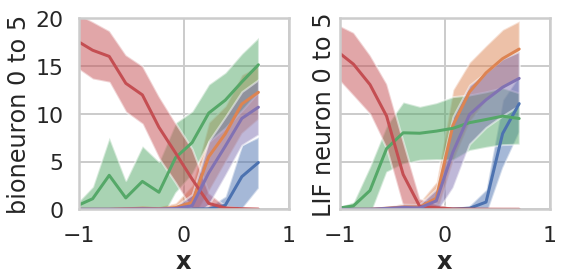

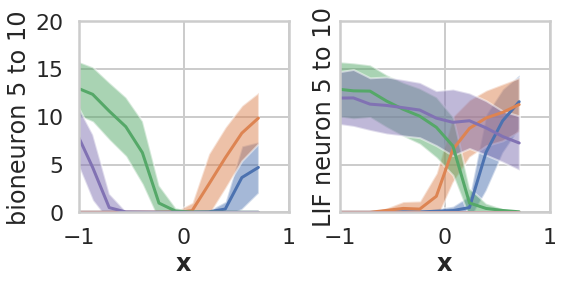

nonzero neurons: 9


In [5]:
reg = 0.1
n_neurons = 10
tau = 0.1
d0 = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(10, 20)
intercepts=Uniform(-0.8, 0.8)
t = 10
dt = 0.001
dt_neuron = 0.025  # ms
freq = 1
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False, conn_opt=True)
stim_func = nengo.processes.WhiteSignal(period=t, high=freq, rms=1, seed=seed)

t0, tar01, s01, v01, tar02, s02, v02, l01, l02, gain0, bias0 = go(
    n_neurons, t=t, dt=dt, d=d0, freq=freq, tau=tau, seed=seed,
    max_rates=rates, intercepts=intercepts, stim_func=stim_func,
    neuron_type=neuron_type)

tar01 = Lowpass(tau).filt(tar01)
a01 = Lowpass(tau).filt(s01)
al01 = Lowpass(tau).filt(l01)
plot_tuning(tar01, a01, al01, rates, neurons_per_plot=5)
print('nonzero neurons:', np.count_nonzero(np.sum(a01, axis=0)))

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


finding gain and bias given connection details...
target y-int 16.191196332516604
target x-int 0.47945734003974216


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

attempt 0
rate at y-int [11.]
rate at x-int [2.]


attempt 1
rate at y-int [15.]
rate at x-int [5.]
attempt 2
rate at y-int [11.]
rate at x-int [0.]
attempt 3
rate at y-int [11.]
rate at x-int [0.]
attempt 4
rate at y-int [16.]
rate at x-int [2.]
optimized neuron 0
target y-int 19.854449149448307
target x-int 0.0038320094372134017
attempt 0
rate at y-int [11.]
rate at x-int [0.]
attempt 1
rate at y-int [16.]
rate at x-int [0.]
attempt 2
rate at y-int [17.]
rate at x-int [0.]
attempt 3
rate at y-int [18.]
rate at x-int [0.]
attempt 4
rate at y-int [19.]
rate at x-int [0.]
attempt 5
rate at y-int [16.]
rate at x-int [0.]
attempt 6
rate at y-int [19.]
rate at x-int [0.]
attempt 7
rate at y-int [20.]
rate at x-int [0.]
attempt 8
rate at y-int [20.]
rate at x-int [0.]
attempt 9
rate at y-int [21.]
rate at x-int [0.]
attempt 10
rate at y-int [22.]
rate at x-int [1.]
optimized neuron 1
target y-int 10.326438659625923
target x-int -0.6668961780848037
attempt 0
rate at y-int [15.]
rate at x-int [0.]
attempt 1
rate at y-int [2.]
rate at x-int [0

/home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'biasspike' on '<Ensemble "ens">'. Did you mean to change an existing attribute?
  SyntaxWarning)


attempt 24
rate at y-int [11.]
rate at x-int [2.]
optimized neuron 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


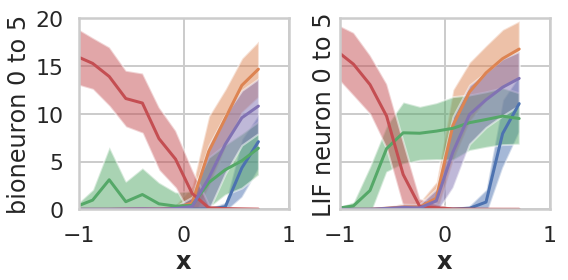

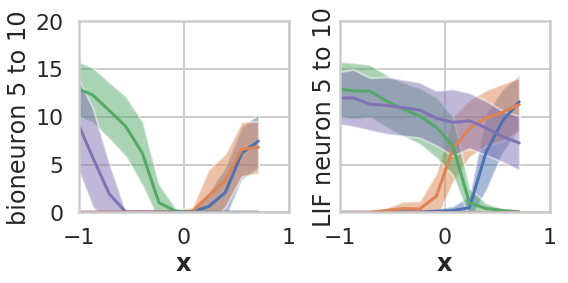

nonzero neurons: 9


In [5]:
reg = 0.1
n_neurons = 10
tau = 0.1
d0 = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(10, 20)
intercepts=Uniform(-0.8, 0.8)
t = 10
dt = 0.001
dt_neuron = 0.025  # ms
freq = 1
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron, DA=False, conn_opt=True)
stim_func = nengo.processes.WhiteSignal(period=t, high=freq, rms=1, seed=seed)

t0, tar01, s01, v01, tar02, s02, v02, l01, l02, gain0, bias0 = go(
    n_neurons, t=t, dt=dt, d=d0, freq=freq, tau=tau, seed=seed,
    max_rates=rates, intercepts=intercepts, stim_func=stim_func,
    neuron_type=neuron_type)

tar01 = Lowpass(tau).filt(tar01)
a01 = Lowpass(tau).filt(s01)
al01 = Lowpass(tau).filt(l01)
plot_tuning(tar01, a01, al01, rates, neurons_per_plot=5)
print('nonzero neurons:', np.count_nonzero(np.sum(a01, axis=0)))